_This notebook contains the code examples of [my personal blog on Machine Learning](https://leadership.qubitpi.org/posts/machine-learning/)_

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/QubitPi/machine-learning/blob/master/01_the_machine_learning_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/QubitPi/machine-learning/blob/master/01_the_machine_learning_landscape.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Scikit-Learn ≥1.0.1 is required:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Let's define the default font sizes, to plot pretty figures:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Make this notebook's output stable across runs:

In [4]:
import numpy as np

np.random.seed(42)

In [5]:
import pandas as pd

# Model-Based Learning

Suppose we want to know if money makes people happy, so we download the Better Life Index data from the [OECD’s website](https://www.oecdbetterlifeindex.org/) and [World Bank stats](https://ourworldindata.org/) about gross domestic product (GDP) per capita. Then we join the tables and sort by GDP per capita.

Create a function to save the figures:

In [6]:
from pathlib import Path

# Where to save the figures
IMAGES_PATH = Path() / "images" / "fundamentals"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Load and prepare Life satisfaction data

To create `lifesat.csv`, we download the Better Life Index (BLI) data (from 2020) from [OECD's website](http://stats.oecd.org/index.aspx?DataSetCode=BLI) (to get the Life Satisfaction for each country), and World Bank GDP per capita data (up to 2020) from [OurWorldInData.org](https://ourworldindata.org/grapher/gdp-per-capita-worldbank). If we want to grab the latest versions, please feel free to do so. However, there may be some changes (e.g., in the column names, or different countries missing data), so be prepared to have to tweak the code.

The data has already be downloaded beforehand so we can read them now:

In [7]:
oecd_bli = pd.read_csv("data/oecd_bli.csv")
gdp_per_capita = pd.read_csv("data/gdp_per_capita.csv")

Preprocess the GDP per capita data to keep only the year 2020:

In [8]:
gdp_year = 2020
gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == gdp_year]
gdp_per_capita = gdp_per_capita.drop(["Code", "Year"], axis=1)
gdp_per_capita.columns = ["Country", gdppc_col]
gdp_per_capita.set_index("Country", inplace=True)

gdp_per_capita.head()

GDP per capita (USD)
Country                                          
Afghanistan                           1978.961579
Africa Eastern and Southern           3387.594670
Africa Western and Central            4003.158913
Albania                              13295.410885
Algeria                              10681.679297

Preprocess the OECD BLI data to keep only the `Life satisfaction` column:

In [9]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

oecd_bli.head()

Indicator  Air pollution  Dwellings without basic facilities  \
Country                                                        
Australia            5.0                                 NaN   
Austria             16.0                                 0.9   
Belgium             15.0                                 1.9   
Brazil              10.0                                 6.7   
Canada               7.0                                 0.2   

Indicator  Educational attainment  Employees working very long hours  \
Country                                                                
Australia                    81.0                              13.04   
Austria                      85.0                               6.66   
Belgium                      77.0                               4.75   
Brazil                       49.0                               7.13   
Canada                       91.0                               3.69   

Indicator  Employment rate  Feeling safe walking alone at night  \
Country                                                           
Australia             73.0                                 63.5   
Austria               72.0                                 80.6   
Belgium               63.0                                 70.1   
Brazil                61.0                                 35.6   
Canada                73.0                                 82.2   

Indicator  Homicide rate  Household net adjusted disposable income  \
Country                                                              
Australia            1.1                                   32759.0   
Austria              0.5                                   33541.0   
Belgium              1.0                                   30364.0   
Brazil              26.7                                       NaN   
Canada               1.3                                   30854.0   

Indicator  Household net wealth  Housing expenditure  ...  Personal earnings  \
Country                                               ...                      
Australia              427064.0                 20.0  ...            49126.0   
Austria                308325.0                 21.0  ...            50349.0   
Belgium                386006.0                 21.0  ...            49675.0   
Brazil                      NaN                  NaN  ...                NaN   
Canada                 423849.0                 22.0  ...            47622.0   

Indicator  Quality of support network  Rooms per person  Self-reported health  \
Country                                                                         
Australia                        95.0               NaN                  85.0   
Austria                          92.0               1.6                  70.0   
Belgium                          91.0               2.2                  74.0   
Brazil                           90.0               NaN                   NaN   
Canada                           93.0               2.6                  88.0   

Indicator  Stakeholder engagement for developing regulations  Student skills  \
Country                                                                        
Australia                                                2.7           502.0   
Austria                                                  1.3           492.0   
Belgium                                                  2.0           503.0   
Brazil                                                   2.2           395.0   
Canada                                                   2.9           523.0   

Indicator  Time devoted to leisure and personal care  Voter turnout  \
Country                                                               
Australia                                      14.35           91.0   
Austria                                        14.55           80.0   
Belgium                                        15.70           89.0   
Brazil                                  

Now let's merge the life satisfaction data and the GDP per capita data, keeping only the GDP per capita and Life satisfaction columns:

In [10]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                              left_index=True, right_index=True)
full_country_stats.sort_values(by=gdppc_col, inplace=True)
full_country_stats = full_country_stats[[gdppc_col, lifesat_col]]

full_country_stats.head()

GDP per capita (USD)  Life satisfaction
Country                                              
South Africa          11466.189672                4.7
Colombia              13441.492952                6.3
Brazil                14063.982505                6.4
Mexico                17887.750736                6.5
Chile                 23324.524751                6.5

To illustrate the risk of overfitting, we will use only part of the data in most figures (all countries with a GDP per capita between `min_gdp` and `max_gdp`). Later we shall reveal the missing countries, and show that they don't follow the same linear trend at all.

In [11]:
min_gdp = 23_500
max_gdp = 62_500

country_stats = full_country_stats[(full_country_stats[gdppc_col] >= min_gdp) &
                                   (full_country_stats[gdppc_col] <= max_gdp)]
country_stats.head()

GDP per capita (USD)  Life satisfaction
Country                                         
Russia           26456.387938                5.8
Greece           27287.083401                5.4
Turkey           28384.987785                5.5
Latvia           29932.493910                5.9
Hungary          31007.768407                5.6

In [12]:
country_stats.to_csv("data/lifesat.csv")
full_country_stats.to_csv("data/lifesat_full.csv")

Let's plot the data:

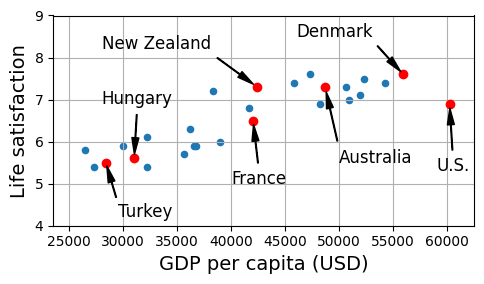

In [13]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

min_life_sat = 4
max_life_sat = 9

position_text = {
    "Turkey": (29_500, 4.2),
    "Hungary": (28_000, 6.9),
    "France": (40_000, 5),
    "New Zealand": (28_000, 8.2),
    "Australia": (50_000, 5.5),
    "United States": (59_000, 5.3),
    "Denmark": (46_000, 8.5)
}

for country, pos_text in position_text.items():
    pos_data_x = country_stats[gdppc_col].loc[country]
    pos_data_y = country_stats[lifesat_col].loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('money_happy_scatterplot')
plt.show()

In [14]:
highlighted_countries = country_stats.loc[list(position_text.keys())]
highlighted_countries[[gdppc_col, lifesat_col]].sort_values(by=gdppc_col)

GDP per capita (USD)  Life satisfaction
Country                                               
Turkey                 28384.987785                5.5
Hungary                31007.768407                5.6
France                 42025.617373                6.5
New Zealand            42404.393738                7.3
Australia              48697.837028                7.3
Denmark                55938.212809                7.6
United States          60235.728492                6.9

There does seem to be a trend. It looks like life satisfaction goes up more or less linearly as the country’s GDP per capita increases. So let's try to model life satisfaction as a linear function of GDP per capita. This step is called __model selection__: selecting a linear model of life satisfaction with just one attribute, GDP per capita:

$$ \text{life satisfaction} = \theta_0 + \theta_1\times(\text{GDP per capita}) $$

This model has 2 __model parameters__, $\theta_0$ and $\theta_1$. Here we tweak the parameters by guessing as shown:

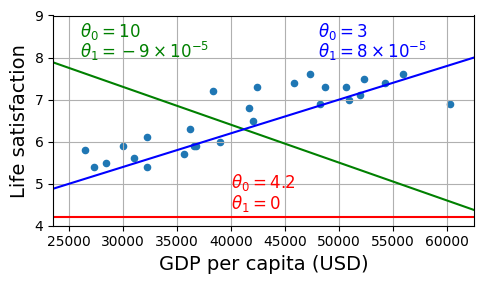

In [15]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)

w1, w2 = 4.2, 0
plt.plot(X, w1 + w2 * 1e-5 * X, "r")
plt.text(40_000, 4.9, fr"$\theta_0 = {w1}$", color="r")
plt.text(40_000, 4.4, fr"$\theta_1 = {w2}$", color="r")

w1, w2 = 10, -9
plt.plot(X, w1 + w2 * 1e-5 * X, "g")
plt.text(26_000, 8.5, fr"$\theta_0 = {w1}$", color="g")
plt.text(26_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="g")

w1, w2 = 3, 8
plt.plot(X, w1 + w2 * 1e-5 * X, "b")
plt.text(48_000, 8.5, fr"$\theta_0 = {w1}$", color="b")
plt.text(48_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('tweaking_model_params_plot')
plt.show()

This is where the linear regression algorithm comes in: we feed it our training examples, and it finds the parameters that make the linear model fit best to our data. This is called __training__ the model. In our case, the algorithm finds that the optimal parameter values are $\theta = 3.75$ and $\theta_1 = 6.78 × 10^{–5}$ as the code below illustrates:

In [16]:
from sklearn import linear_model

X_sample = country_stats[[gdppc_col]].values
y_sample = country_stats[[lifesat_col]].values

lin1 = linear_model.LinearRegression()
lin1.fit(X_sample, y_sample)

t0, t1 = lin1.intercept_[0], lin1.coef_.ravel()[0]
print(f"θ_0={t0:.2f}, θ_1={t1:.2e}")

θ_0=3.75, θ_1=6.78e-05


> ⚠️ Confusingly, the word “model” can refer to a _type of_ model (e.g., linear regression), to a _fully specified model architecture_ (e.g., linear regression with one input and one output), or to the _final trained model_ ready to be used for predictions (e.g., linear regression with one input and one output, using $\theta = 3.75$ and $\theta_1 = 6.78 × 10^{–5}$). Model selection consists in choosing the type of model and fully specifying its architecture. Training a model means running an algorithm to find the model parameters that will make it best fit the training data, and hopefully make good predictions on new data.

Now the model fits the training data as closely as possible (for a linear model), as we can see in

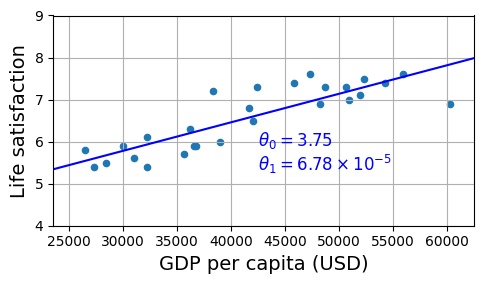

In [17]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X, t0 + t1 * X, "b")

plt.text(max_gdp - 20_000, min_life_sat + 1.9,
         fr"$\theta_0 = {t0:.2f}$", color="b")
plt.text(max_gdp - 20_000, min_life_sat + 1.3,
         fr"$\theta_1 = {t1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('best_fit_model_plot')
plt.show()

We are finally ready to run the model to make predictions. For example, say we want to know how happy Cypriots are, but the OECD data does not have the answer. Fortunately, we can use our model to make a good prediction: we look up Cyprus’s GDP per capita and find its $37,655

In [18]:
cyprus_gdp_per_capita = gdp_per_capita[gdppc_col].loc["Cyprus"]
cyprus_gdp_per_capita

37655.1803457421

and then apply our model and find that life satisfaction is likely to be somewhere around $3.75 + 37,655 × 6.78 × 10^{–5} = 6.30$.

In [19]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0, 0]
cyprus_predicted_life_satisfaction

6.301656332738056

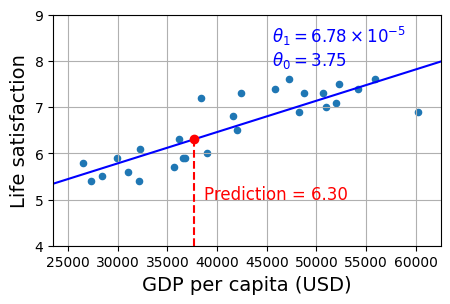

In [20]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X, t0 + t1 * X, "b")

plt.text(min_gdp + 22_000, max_life_sat - 1.1,
         fr"$\theta_0 = {t0:.2f}$", color="b")
plt.text(min_gdp + 22_000, max_life_sat - 0.6,
         fr"$\theta_1 = {t1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita],
         [min_life_sat, cyprus_predicted_life_satisfaction], "r--")
plt.text(cyprus_gdp_per_capita + 1000, 5.0,
         fr"Prediction = {cyprus_predicted_life_satisfaction:.2f}", color="r")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

plt.show()

Note that if we had used an instance-based learning algorithm instead, we would have found that Israel has the closest GDP per capita to that of Cyprus ($38,341), and since the OECD data tells us that Israelis’ life satisfaction is 7.2, we would have predicted a life satisfaction of 7.2 for Cyprus. The model-based learning algorithm tells an answer that is somewhat different:

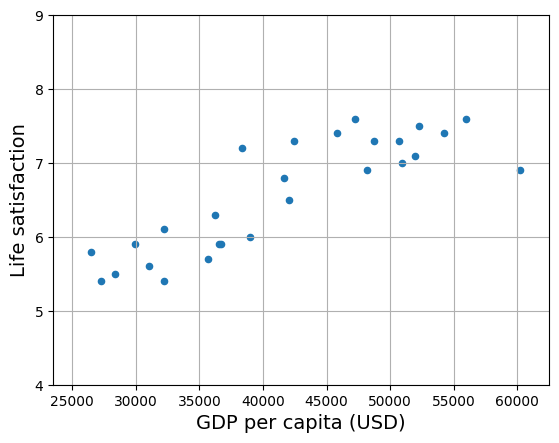

[[6.30165767]]


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load and prepare the data
lifesat = pd.read_csv("data/lifesat.csv")
X = lifesat[["GDP per capita (USD)"]].values
y = lifesat[["Life satisfaction"]].values

# Visualize the data
lifesat.plot(kind='scatter', grid=True,
             x="GDP per capita (USD)", y="Life satisfaction")
plt.axis([23_500, 62_500, 4, 9])
plt.show()

# Select a linear model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[37_655.2]]  # Cyprus' GDP per capita in 2020
print(model.predict(X_new)) # outputs [[6.30165767]]

But we will also find Lithuania and Slovenia, both with a life satisfaction of 5.9. Averaging these three values, we get 6.33, which is pretty close to our model-based prediction. This simple algorithm is called __k-nearest neighbors regression__ (in this example, k = 3).

Replacing the Linear Regression model with k-Nearest Neighbors (in this example, k = 3) regression in the previous code is as simple as replacing these two lines:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

with these two:

```python
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)
```

In [22]:
# Select a 3-Nearest Neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
print(model.predict(X_new)) # outputs [[6.33333333]]

[[6.33333333]]


If all went well, our model will make good predictions. If not, we may need to use more attributes (employment rate, health, air pollution, etc.), get more or better-quality training data, or perhaps select a more powerful model (e.g., a polynomial regression model).

We have so far:

- studied the data
- selected a model
- trained it on the training data (i.e., the learning algorithm searched for the model parameter values that minimize a cost function)
- applied the model to make predictions on new cases (this is called __inference__), hoping that this model will generalize well

_This is what a typical machine learning project looks like_

Nonrepresentative Training Data
-------------------------------

The set of countries we used earlier for training the linear model was not perfectly representative; it did not contain any country with a GDP per capita lower than \\$23,500 or higher than \\$62,500:

In [23]:
missing_data = full_country_stats[(full_country_stats[gdppc_col] < min_gdp) |
                                  (full_country_stats[gdppc_col] > max_gdp)]
missing_data

GDP per capita (USD)  Life satisfaction
Country                                              
South Africa          11466.189672                4.7
Colombia              13441.492952                6.3
Brazil                14063.982505                6.4
Mexico                17887.750736                6.5
Chile                 23324.524751                6.5
Norway                63585.903514                7.6
Switzerland           68393.306004                7.5
Ireland               89688.956958                7.0
Luxembourg           110261.157353                6.9

Let's see what the data looks like when we add such countries

In [24]:
position_text_missing_countries = {
    "South Africa": (20_000, 4.2),
    "Colombia": (6_000, 8.2),
    "Brazil": (18_000, 7.8),
    "Mexico": (24_000, 7.4),
    "Chile": (30_000, 7.0),
    "Norway": (51_000, 6.2),
    "Switzerland": (62_000, 5.7),
    "Ireland": (81_000, 5.2),
    "Luxembourg": (92_000, 4.7),
}

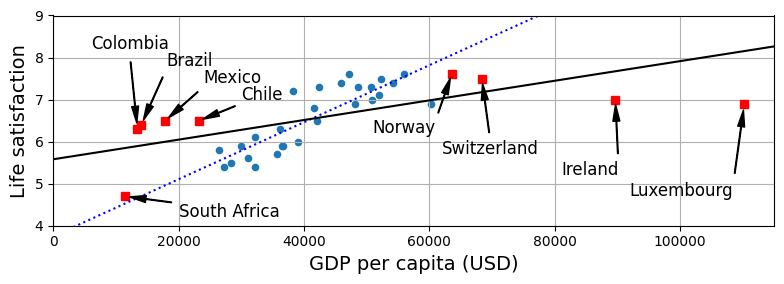

In [25]:
full_country_stats.plot(kind='scatter', figsize=(8, 3),
                        x=gdppc_col, y=lifesat_col, grid=True)

for country, pos_text in position_text_missing_countries.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0 + t1 * X, "b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats[gdppc_col]]
yfull = np.c_[full_country_stats[lifesat_col]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_.ravel()[0]
X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0full + t1full * X, "k")

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('representative_training_data_scatterplot')
plt.show()

If we train a linear model on this data, we get the solid line, while the old model is represented by the dotted line. As we can see, not only does adding a few missing countries significantly alter the model, but it makes it clear that such a simple linear model is probably never going to work well. It seems that very rich countries are not happier than moderately rich countries (in fact, they seem slightly unhappier!), and conversely some poor countries seem happier than many rich countries.

By using a nonrepresentative training set, we trained a model that is unlikely to make accurate predictions, especially for very poor and very rich countries.

Overfitting the Training Data
-----------------------------

The code below shows an example of a high-degree polynomial life satisfaction model that strongly overfits the training data. Even though it performs much better on the training data than the simple linear model, would we really trust its predictions?

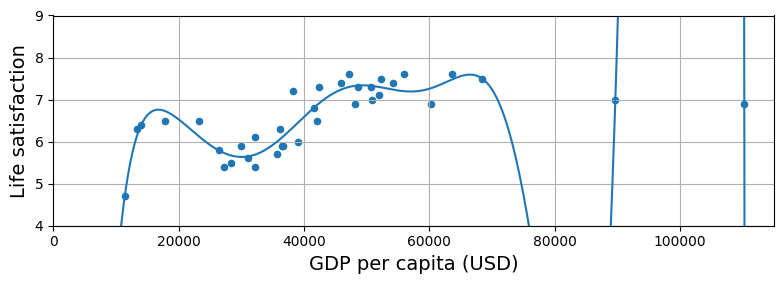

In [26]:
from sklearn import preprocessing
from sklearn import pipeline

full_country_stats.plot(kind='scatter', figsize=(8, 3),
                        x=gdppc_col, y=lifesat_col, grid=True)

poly = preprocessing.PolynomialFeatures(degree=10, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([
    ('poly', poly),
    ('scal', scaler),
    ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('overfitting_model_plot')
plt.show()

Complex models such as deep neural networks can detect subtle patterns in the data, but if the training set is noisy, or if it is too small, which introduces sampling noise, then the model is likely to detect patterns in the noise itself (as in the taxi driver example). Obviously these patterns will not generalize to new instances. For example, say we feed our life satisfaction model many more attributes, including uninformative ones such as the country’s name. In that case, a complex model may detect patterns like the fact that all countries in the training data with a w in their name have a life satisfaction greater than 7: New Zealand (7.3), Norway (7.6), Sweden (7.3), and Switzerland (7.5). How confident are we that the w-satisfaction rule generalizes to Rwanda or Zimbabwe? Obviously this pattern occurred in the training data by pure chance, but the model has no way to tell whether a pattern is real or simply the result of noise in the data.

Overfitting happens when the model is too complex relative to the amount and noisiness of the training data. Here are possible solutions:

1. Simplify the model by selecting one with fewer parameters (e.g., a linear model rather than a high-degree polynomial model), by reducing the number of attributes in the training data, or by constraining the model.
2. Gather more training data.

Constraining a model to make it simpler and reduce the risk of overfitting is called __regularization__. For example, the linear model we defined earlier has two parameters, $\theta_0$ and $\theta_1$. This gives the learning algorithm 2 degrees of freedom to adapt the model to the training data: it can tweak both the height ($\theta_0$) and the slope ($\theta_1$) of the line. If we forced $\theta_1 = 0$, the algorithm would have only one degree of freedom and would have a much harder time fitting the data properly: all it could do is move the line up or down to get as close as possible to the training instances, so it would end up around the mean. A very simple model indeed! If we allow the algorithm to modify $\theta_1$ but we force it to keep it small, then the learning algorithm will effectively have somewhere in between one and two degrees of freedom. It will produce a model that’s simpler than one with two degrees of freedom, but more complex than one with just one. We want to find the right balance between fitting the training data perfectly and keeping the model simple enough to ensure that it will generalize well.

To illustrate that, we show three models below. The dotted line represents the original model that was trained on the countries represented as circles (without the countries represented as squares), the solid line is our second model trained with all countries (circles and squares), and the dashed line is a model trained with the same data as the first model but with a regularization constraint. We can see that regularization forced the model to have a smaller slope: this model does not fit the training data (circles) as well as the first model, but it actually generalizes better to new examples that it did not see during training (squares).

In [27]:
w_countries = [c for c in full_country_stats.index if "W" in c.upper()]
full_country_stats.loc[w_countries][lifesat_col]

Country
New Zealand    7.3
Sweden         7.3
Norway         7.6
Switzerland    7.5
Name: Life satisfaction, dtype: float64

In [28]:
all_w_countries = [c for c in gdp_per_capita.index if "W" in c.upper()]
gdp_per_capita.loc[all_w_countries].sort_values(by=gdppc_col)

GDP per capita (USD)
Country                                         
Malawi                               1486.778248
Rwanda                               2098.710362
Zimbabwe                             2744.690758
Africa Western and Central           4003.158913
Papua New Guinea                     4101.218882
Lower middle income                  6722.809932
Eswatini                             8392.717564
Low & middle income                 10293.855325
Arab World                          13753.707307
Botswana                            16040.008473
World                               16194.040310
New Zealand                         42404.393738
Sweden                              50683.323510
Norway                              63585.903514
Switzerland                         68393.306004

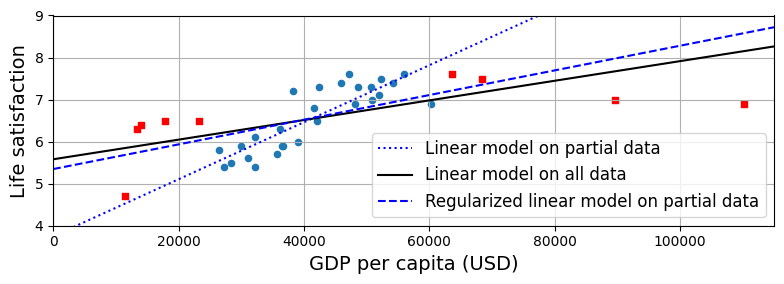

In [29]:
country_stats.plot(kind='scatter', x=gdppc_col, y=lifesat_col, figsize=(8, 3))
missing_data.plot(kind='scatter', x=gdppc_col, y=lifesat_col,
                  marker="s", color="r", grid=True, ax=plt.gca())

X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")
plt.plot(X, t0full + t1full * X, "k-", label="Linear model on all data")

ridge = linear_model.Ridge(alpha=10**9.5)
X_sample = country_stats[[gdppc_col]]
y_sample = country_stats[[lifesat_col]]
ridge.fit(X_sample, y_sample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_.ravel()[0]
plt.plot(X, t0ridge + t1ridge * X, "b--",
         label="Regularized linear model on partial data")
plt.legend(loc="lower right")

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('ridge_model_plot')
plt.show()

The amount of regularization to apply during learning can be controlled by a hyperparameter. A __hyperparameter__ is a parameter of a learning algorithm (not of the model). As such, it is not affected by the learning algorithm itself; it must be set prior to training and remains constant during training. Learning rate is one example of hyperparameter. Tuning hyperparameters is an important part of building a machine learning system